In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [2]:
df_train = pd.read_csv('../../data_new/train_pre.csv').drop_duplicates()
df_test = pd.read_csv('../../data_new/test_pre.csv').drop_duplicates()

In [3]:
def pooled_var(stds):
    n = 3 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

In [4]:
def plot_cv_results(gs_model, gs_params):
    df = pd.DataFrame(gs_model.cv_results_)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']


    fig, axes = plt.subplots(1, len(gs_params), 
                            figsize = (5*len(gs_params), 7),
                            sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)
    lw = 2

    for idx, (param_name, param_range) in enumerate(gs_params.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [5]:
def get_score(pred, actual):
    if np.argmin(pred) == np.argmin(actual):
        return 1
    return 0

In [18]:
def get_metrics(model, x, y):
    precision = 0
    accuracy = 0
    recall = 0
    f1 = 0
    score = 0
    for i in x['raceId'].unique():
        X_test = x[x['raceId'] == i]
        Y_test = y[x[x['raceId'] == i].index]

        predicted_scores = model.predict(X_test.drop(columns = ['results_positionOrder']))
        predicted_podium = np.argsort(predicted_scores)
        # print(self.position[x[x['raceId'] == i].index])
        actual_podium = Y_test.to_numpy()
        actual_podium = np.argsort(actual_podium)
        # print(predicted_scores)

        predictions = np.zeros(len(Y_test))
        # predictions[predicted_podium] = 1
        actual = np.zeros(len(Y_test))
        # actual[actual_podium] = 1

        for i in range(1):
            predictions[predicted_podium[i]] = 1
            # print(actual_podium)
            actual[actual_podium[i]] = 1

        precision += precision_score(actual, predictions)
        accuracy += accuracy_score(actual, predictions)
        recall += recall_score(actual, predictions)
        f1 += f1_score(actual, predictions) 
        score += get_score(predicted_podium, actual_podium)
    return precision/len(x['raceId'].unique()), accuracy/len(x['raceId'].unique()), recall/len(x['raceId'].unique()), f1/len(x['raceId'].unique()), score/len(x['raceId'].unique())
        

In [7]:
class customCrossValidation():

    def split(self, x):
        indices = []
        for i in range(3):
            years = x['year'].unique()
            np.random.shuffle(years)
            val_years = years[:6]
            train_years = years[6:]

            indices.append((x[x['year'].isin(train_years)].index, x[x['year'].isin(val_years)].index))
        return indices

##### Ridge Regression

In [8]:
class MLPClassification() :

    def scoring(self, model, x, y):

        precision = 0
        accuracy = 0
        recall = 0
        f1 = 0
        score = 0
        for i in x['raceId'].unique():
            X_test = x[x['raceId'] == i]
            Y_test = y[x[x['raceId'] == i].index]

            predicted_scores = model.predict(X_test)
            predicted_podium = np.argsort(predicted_scores)
            # print(self.position[x[x['raceId'] == i].index])
            actual_podium = self.position[x[x['raceId'] == i].index].to_numpy()
            actual_podium = np.argsort(actual_podium)
            # print(predicted_scores)

            predictions = np.zeros(len(Y_test))
            # predictions[predicted_podium] = 1
            actual = np.zeros(len(Y_test))
            # actual[actual_podium] = 1

            for i in range(1):
                predictions[predicted_podium[i]] = 1
                # print(actual_podium)
                actual[actual_podium[i]] = 1

            precision += precision_score(actual, predictions)
            accuracy += accuracy_score(actual, predictions)
            recall += recall_score(actual, predictions)
            f1 += f1_score(actual, predictions) 
            score += get_score(predicted_podium, actual_podium)
        
        # self.ridge_metrics = {'precision': precision/len(x['raceId'].unique()), 'accuracy': accuracy/len(x['raceId'].unique()), 'recall': recall/len(x['raceId'].unique()), 'f1': f1/len(x['raceId'].unique())}
        return precision/len(x['raceId'].unique())

    def find_best_param_mlp(self, x, y):

        self.x = x
        self.y = y
        self.position = x['results_positionOrder']

        splitter = customCrossValidation().split(x)
        self.hyper_params = [{'activation': ['relu', 'logistic', 'identity', 'tanh'], 'solver': ['adam', 'sgd'], 'alpha': [0.001, 0.01, 0.1, 1], 'hidden_layer_sizes': [(256,32), (128,16),(64,8)]}]

        model_mlp = MLPClassifier()
        self.model_cv = GridSearchCV(estimator=model_mlp, param_grid=self.hyper_params, scoring=self.scoring, cv = splitter, return_train_score=True, verbose = 3)
        self.model_cv.fit(x.drop(columns = ['results_positionOrder']), y)
        self.mlp_params = self.model_cv.best_params_

    def fit_mlp(self, x, y):
        model = MLPClassifier(**self.mlp_params)
        model.fit(x.drop(columns = ['results_positionOrder']), y)
        self.model = model
        return
        


In [9]:
mlpClassifier = MLPClassification()

In [10]:
mlpClassifier.find_best_param_mlp(df_train.drop(columns = ['results_points']), df_train['results_positionOrder'])

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.065, test=0.037) total time=   7.8s
[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.068, test=0.020) total time=   7.3s
[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.057, test=0.126) total time=   8.2s
[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.065, test=0.037) total time=  10.3s
[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.068, test=0.020) total time=   8.7s
[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.057, test=0.126) total time=   7.8s
[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.065, test=0

C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.065, test=0.037) total time=  40.5s
[CV 2/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.068, test=0.020) total time=   2.8s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.057, test=0.126) total time=  40.2s
[CV 1/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.065, test=0.037) total time=   4.2s
[CV 2/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.068, test=0.020) total time=   4.4s
[CV 3/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.057, test=0.126) total time=   4.8s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.065, test=0.037) total time=  22.9s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.068, test=0.020) total time=  23.3s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.057, test=0.126) total time=  23.0s
[CV 1/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.065, test=0.037) total time=   2.3s
[CV 2/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.068, test=0.020) total time=   2.4s
[CV 3/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.057, test=0.126) total time=   2.8s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.065, test=0.037) total time=  11.6s
[CV 2/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.068, test=0.020) total time=   3.6s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.057, test=0.126) total time=  10.8s
[CV 1/3] END activation=relu, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.065, test=0.037) total time=  37.1s
[CV 2/3] END activation=relu, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.068, test=0.020) total time=  33.8s
[CV 3/3] END activation=relu, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.057, test=0.126) total time=  42.5s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.065, test=0.037) total time=  44.7s
[CV 2/3] END activation=relu, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.068, test=0.020) total time=   3.0s
[CV 3/3] END activation=relu, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.057, test=0.126) total time=   3.1s
[CV 1/3] END activation=relu, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.065, test=0.037) total time=  19.0s
[CV 2/3] END activation=relu, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.068, test=0.020) total time=  19.2s
[CV 3/3] END activation=relu, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.057, test=0.126) total time=  18.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.065, test=0.037) total time=  22.3s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.068, test=0.020) total time=  22.7s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.057, test=0.126) total time=  22.5s
[CV 1/3] END activation=relu, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.065, test=0.037) total time=   9.3s
[CV 2/3] END activation=relu, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.068, test=0.020) total time=  10.8s
[CV 3/3] END activation=relu, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.057, test=0.126) total time=   9.2s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.065, test=0.037) total time=  11.2s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.068, test=0.020) total time=  11.7s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.057, test=0.126) total time=  11.1s
[CV 1/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.425, test=0.346) total time=  20.1s
[CV 2/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.438, test=0.333) total time=  33.8s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.418, test=0.425) total time=  16.9s
[CV 1/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.065, test=0.037) total time=  18.9s
[CV 2/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.068, test=0.020) total time=  24.7s
[CV 3/3] END activation=logistic, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.057, test=0.126) total time=  21.8s
[CV 1/3] END activat

C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.440, test=0.395) total time=  12.3s
[CV 2/3] END activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.455, test=0.412) total time=   7.5s
[CV 3/3] END activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.442, test=0.379) total time=  10.4s
[CV 1/3] END activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.065, test=0.037) total time=   9.4s
[CV 2/3] END activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.068, test=0.020) total time=  10.8s
[CV 3/3] END activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.057, test=0.126) total time=   6.7s
[CV 1/3] END activation=logistic, alpha=0.1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.438, test=0.444) total time=  26.9s
[CV 2/3] END activation=logis

C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.432, test=0.444) total time=  12.7s
[CV 2/3] END activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.068, test=0.020) total time=   6.3s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.245, test=0.299) total time=  12.6s
[CV 1/3] END activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.065, test=0.037) total time=  10.2s
[CV 2/3] END activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.068, test=0.020) total time=   1.8s
[CV 3/3] END activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.057, test=0.126) total time=   8.9s
[CV 1/3] END activation=logistic, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.065, test=0.037) total time=   8.8s
[CV 2/3] END activation=logistic, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.068, test=0.020) total time=   9.7s
[CV 3/3] END activation=logistic, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.057, test=0.126) total time=   9.9s
[CV 1/3] END activation=logistic, alp

C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.068, test=0.020) total time=  44.1s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.057, test=0.126) total time=  44.6s
[CV 1/3] END activation=logistic, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.065, test=0.037) total time=   6.0s
[CV 2/3] END activation=logistic, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.068, test=0.020) total time=   4.3s
[CV 3/3] END activation=logistic, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.057, test=0.126) total time=   4.4s
[CV 1/3] END activation=logistic, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.065, test=0.037) total time=  19.7s
[CV 2/3] END activation=logistic, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.068, test=0.020) total time=  19.8s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.057, test=0.126) total time=  24.1s
[CV 1/3] END activation=logistic, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.065, test=0.037) total time=   4.0s
[CV 2/3] END activation=logistic, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.068, test=0.020) total time=   3.0s
[CV 3/3] END activation=logistic, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.057, test=0.126) total time=   3.6s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.065, test=0.037) total time=  11.7s
[CV 2/3] END activation=logistic, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.068, test=0.020) total time=  11.2s
[CV 3/3] END activation=logistic, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.057, test=0.126) total time=  11.0s
[CV 1/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.378, test=0.358) total time=  20.0s
[CV 2/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.419, test=0.510) total time=  23.2s
[CV 3/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.443, test=0.448) total time=  18.7s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  36.2s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  35.3s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  36.6s
[CV 1/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.430, test=0.358) total time=   9.9s
[CV 2/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.403, test=0.480) total time=   9.0s
[CV 3/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.375, test=0.414) total time=   4.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  20.1s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  19.7s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  19.9s
[CV 1/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.436, test=0.370) total time=   5.8s
[CV 2/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.421, test=0.471) total time=   5.4s
[CV 3/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.369, test=0.391) total time=   5.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  11.5s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  10.9s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.001, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  11.7s
[CV 1/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.444, test=0.444) total time=  11.8s
[CV 2/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.376, test=0.353) total time=  22.0s
[CV 3/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.437, test=0.414) total time=  19.2s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  36.2s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  34.5s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  34.7s
[CV 1/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.422, test=0.407) total time=  11.4s
[CV 2/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.259, test=0.284) total time=   6.3s
[CV 3/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.357, test=0.391) total time=  11.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  21.1s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  19.3s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  22.0s
[CV 1/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.438, test=0.370) total time=   6.7s
[CV 2/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.302, test=0.294) total time=   1.4s
[CV 3/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.424, test=0.379) total time=   7.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  11.4s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  12.3s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.01, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  11.1s
[CV 1/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.372, test=0.321) total time=  22.3s
[CV 2/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.364, test=0.353) total time=  19.1s
[CV 3/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.358, test=0.402) total time=   9.9s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  34.9s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  33.2s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  35.2s
[CV 1/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.271, test=0.222) total time=   6.2s
[CV 2/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.418, test=0.471) total time=   3.0s
[CV 3/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.368, test=0.402) total time=   3.5s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  22.4s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  21.8s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  20.1s
[CV 1/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.420, test=0.333) total time=   5.7s
[CV 2/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.255, test=0.284) total time=   2.0s
[CV 3/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.398, test=0.414) total time=   7.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  12.4s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_base.py:66: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]


[CV 2/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  10.7s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=0.1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  10.4s
[CV 1/3] END activation=identity, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.246, test=0.148) total time=  11.1s
[CV 2/3] END activation=identity, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.391, test=0.382) total time=  20.6s
[CV 3/3] END activation=identity, alpha=1, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.072, test=0.138) total time=   9.1s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  36.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  35.1s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=nan, test=nan) total time=  35.3s
[CV 1/3] END activation=identity, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.353, test=0.259) total time=  11.3s
[CV 2/3] END activation=identity, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.385, test=0.343) total time=   9.3s
[CV 3/3] END activation=identity, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.402, test=0.448) total time=  10.3s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/3] END activation=identity, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  20.2s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  20.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=nan, test=nan) total time=  20.1s
[CV 1/3] END activation=identity, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.399, test=0.407) total time=   7.0s
[CV 2/3] END activation=identity, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.309, test=0.186) total time=   5.6s
[CV 3/3] END activation=identity, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.399, test=0.414) total time=   5.1s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_base.py:66: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]


[CV 1/3] END activation=identity, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  10.0s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/3] END activation=identity, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  10.9s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=identity, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=nan, test=nan) total time=  10.5s
[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.345, test=0.395) total time=  18.0s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.406, test=0.353) total time=  24.1s
[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 32), solver=adam;, score=(train=0.464, test=0.402) total time=  20.9s
[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.065, test=0.037) total time=  12.2s
[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.068, test=0.020) total time=  18.5s
[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.057, test=0.126) total time=  16.1s
[CV 1/3] END activation=tanh, alpha=0.001, h

C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=tanh, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.065, test=0.037) total time=  42.4s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=tanh, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.068, test=0.020) total time=  41.8s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=tanh, alpha=1, hidden_layer_sizes=(256, 32), solver=sgd;, score=(train=0.057, test=0.126) total time=  42.0s
[CV 1/3] END activation=tanh, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.065, test=0.037) total time=   9.8s
[CV 2/3] END activation=tanh, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.068, test=0.020) total time=  11.1s
[CV 3/3] END activation=tanh, alpha=1, hidden_layer_sizes=(128, 16), solver=adam;, score=(train=0.057, test=0.126) total time=   7.8s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=tanh, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.065, test=0.037) total time=  23.9s
[CV 2/3] END activation=tanh, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.068, test=0.020) total time=  19.0s
[CV 3/3] END activation=tanh, alpha=1, hidden_layer_sizes=(128, 16), solver=sgd;, score=(train=0.057, test=0.126) total time=42.3min
[CV 1/3] END activation=tanh, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.065, test=0.037) total time=   7.9s
[CV 2/3] END activation=tanh, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.068, test=0.020) total time=   6.2s
[CV 3/3] END activation=tanh, alpha=1, hidden_layer_sizes=(64, 8), solver=adam;, score=(train=0.057, test=0.126) total time=   4.1s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=tanh, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.065, test=0.037) total time=  16.6s
[CV 2/3] END activation=tanh, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.068, test=0.020) total time=  12.8s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=tanh, alpha=1, hidden_layer_sizes=(64, 8), solver=sgd;, score=(train=0.057, test=0.126) total time=  12.3s


C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 762, in fit
    return self._fit(X, y, incremental=False)
  File "C:\Users\asus'\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_networ

In [14]:
mlpClassifier.mlp_params

{'activation': 'identity',
 'alpha': 0.001,
 'hidden_layer_sizes': (256, 32),
 'solver': 'adam'}

In [15]:
mlpClassifier.fit_mlp(df_train.drop(columns = ['results_points']), df_train['results_positionOrder'])

In [19]:
get_metrics(mlpClassifier.model, df_test.drop(columns = ['results_points']), df_test['results_positionOrder'])

(0.46, 0.9535312148432995, 0.46, 0.46, 0.21)

ValueError: 'x' is not 1-dimensional

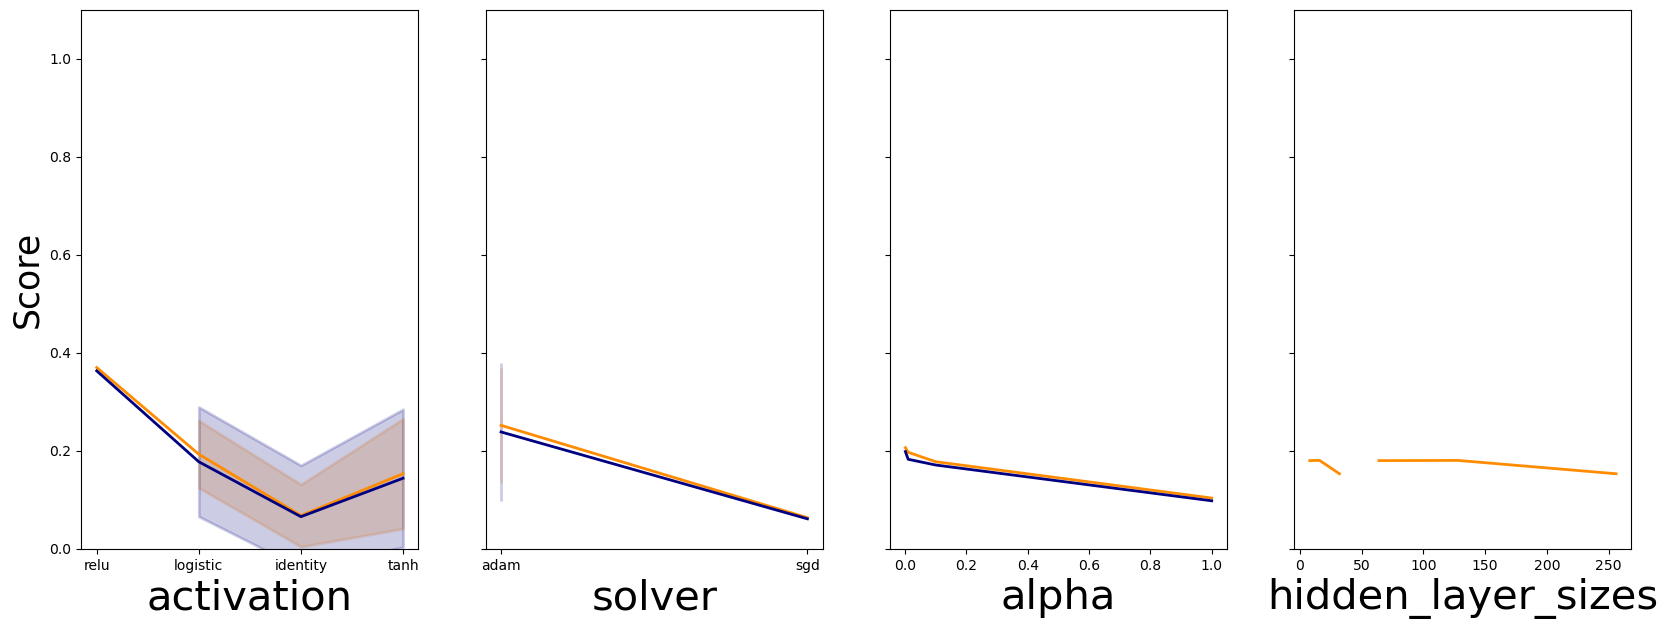

In [17]:
plot_cv_results(mlpClassifier.model_cv, mlpClassifier.hyper_params[0])